In [1]:
import csv
import glob
import re
import pandas as pd
import numpy as np
import seaborn as sns
import pomegranate as pg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sequentia.classifiers import HMM, HMMClassifier, DTWKNN
from sequentia.preprocessing import Preprocess
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams

seed = 0
np.random.seed(seed)
rand = np.random.RandomState(seed=seed)

In [2]:
gestures = ['nd', 'mnd', 'fu', 'fd', 'sh', 't', 'ti']

In [3]:
lag = pd.read_csv('../lag.csv', index_col=0, squeeze=True).to_dict()

In [4]:
class Recording:
    def __init__(self, csv):
        self._name = Path(csv).stem.split('.')[0]
        self._speaker = self._name.split('_')[0]
        self._personality = self._name.split('_')[-1]
        self._path = csv
        
    @property
    def id(self) -> str:
        """The recording identifier."""
        return self._name
    
    @property
    def speaker(self) -> str:
        """The speaker of the recording."""
        return self._speaker
    
    @property
    def path(self) -> str:
        """The path to the rov.csv parameters file."""
        return self._path

class Parameters(Recording):
    def __init__(self, csv):
        super().__init__(csv)
    
    def as_df(self) -> pd.DataFrame:
        """Creates a dataframe from the rov.csv parameters file."""
        
        # Load the annotations
        df = pd.read_csv(self._path).astype(np.float64) 
        
        # Select only the rotation vectors
        df = df[['Rx', 'Ry', 'Rz']]
        
        # Add recording identifier column
        df['recording'] = self._name
        
        return df

class Annotations(Recording):
    def __init__(self, csv):
        self._params = Parameters(
            re.sub('/rov.csv', '/Normalized/rov.csv', 
                   re.sub('eaf.csv', 'rov.csv', 
                          re.sub('annotations', 'params', csv)))
        )
        super().__init__(csv)
    
    @property
    def params(self) -> Parameters:
        """Returns the corresponding {Parameters} object for the annotations."""
        return self._params        
    
    def as_df(self) -> pd.DataFrame:
        """Creates a dataframe from the eaf.csv annotations file."""
        
        # Load the annotations
        df = pd.read_csv(self._path)   
        
        # Select the gesture type, start-time, end-time and duration columns
        df = df[['type', 'start_time', 'end_time', 'during_time']]
        
        # Rename 'during_time' column to 'duration'
        df = df.rename(columns={'type': 'gesture', 'during_time': 'duration'})
        
        # Convert the 'duration' column to an integer
        df = df.astype({'start_time': 'int32', 'end_time': 'int32', 'duration': 'int32'})

        # Convert the units from milliseconds to frames (/1000 and *100)
        df.loc[:, ['start_time', 'end_time', 'duration']] //= 10
        
        # Subtract the lag time
        df[['start_time', 'end_time']] -= round(lag[self._name] * 100)
        
        # Add recording identifier column
        df['recording'] = self._name
        
        # Reorder columns such that 'gesture' is the last column
        df = df[['start_time', 'end_time', 'duration', 'recording', 'gesture']]
        
        # Remove 'start' gestures
        df = df[df['gesture'] != 'start']
        
        return df

In [5]:
# File paths to all annotation CSV files
csvs = glob.glob('../annotations/*/eaf.csv/*.eaf.csv')

# Initialize {Annotations} object for each eaf.csv annotations file
anns = [Annotations(csv) for csv in csvs]
# Remove ones I annotated, without lag measure
anns = [ann for ann in anns if ann.id not in ['sophie_04_e', 'sophie_05_i']]

# Combine the parameters dataframes for each {Annotations} object
param_df = pd.concat(ann.params.as_df() for ann in anns)

# Combine the dataframes for each {Annotations} object
ann_df = pd.concat(ann.as_df() for ann in anns)

# Shuffle the annotations dataframe
ann_df = ann_df.reset_index(drop=True)

# Remove blank gestures
# NOTE: This may be caused by a larger problem, like recording misalignment - look into this!
blank_idx = []
for i, (_, gesture) in enumerate(ann_df.iterrows()):
    start, end, _, recording, _ = gesture 
    gesture_df = param_df[param_df['recording'] == recording].iloc[start:end]
    if gesture_df.empty:
        blank_idx.append(i)  
ann_df.drop(blank_idx, inplace=True)

# Split the annotations dataframe into examples and labels
ann_y = ann_df['gesture'] 
ann_X = ann_df.loc[:, ann_df.columns != 'gesture']

In [6]:
# Convert the dataframe into lists of numpy arrays
X = [param_df[param_df['recording'] == row['recording']].iloc[row['start_time']:row['end_time']][['Rx', 'Ry', 'Rz']].to_numpy() for _, row in ann_X.iterrows()]
y = list(ann_y)

In [7]:
def plot_gesture(O, figsize=(12, 7), title=None):
    title = 'Normalized head rotation vectors for a gesture' if title is None else title
    labels = ['X (Roll)', 'Y (Yaw)', 'Z (Pitch)']
    colors = ['blue', 'red', 'green']
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=figsize)
    for i, ax in enumerate(axs.flat):
        ax.plot(O[:, i], label=labels[i], color=colors[i])
        ax.legend(loc='upper right')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0, top=0.92)
    fig.suptitle(title, fontsize=20)
    plt.show()

In [8]:
# Split the data into training, validation and test sets (65-20-15)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.35, shuffle=True, random_state=rand)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.43, shuffle=True, random_state=rand)
print('Training set size: {}'.format(len(y_train)))
print('Validation set size: {}'.format(len(y_val)))
print('Test set size: {}'.format(len(y_test)))

Training set size: 841
Validation set size: 258
Test set size: 196


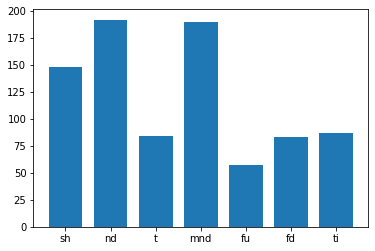

In [9]:
# Display prior counts for each class
classes, values = zip(*Counter(y_train).items())
indexes = np.arange(len(classes))
plt.bar(indexes, values, 0.75)
plt.xticks(indexes, classes)
plt.show()

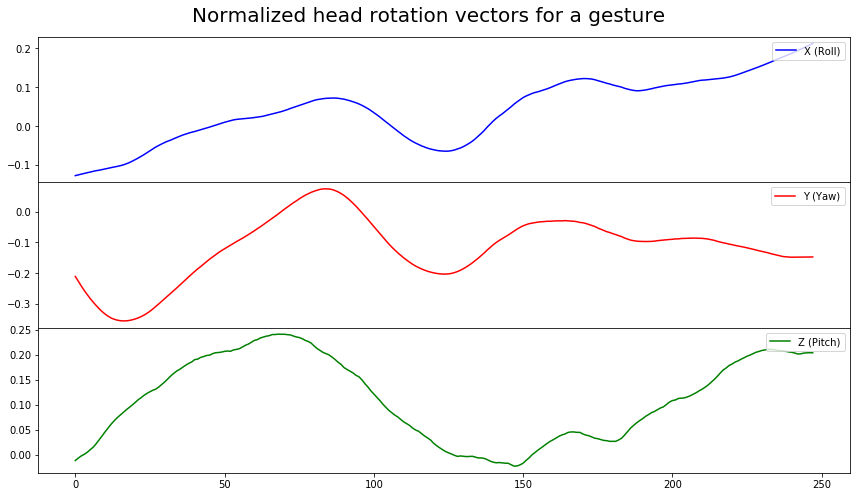

In [10]:
plot_gesture(X_train[0])

In [11]:
pre = Preprocess()
pre.downsample(n=3, method='average')
pre.filtrate(n=5, method='median')
pre.fft()
pre.summary()

          Preprocessing summary:          
1. Downsampling:
   Averaging with downsample factor (n=10)
------------------------------------------
2. Filtering:
   Median filter with window size (n=15)
------------------------------------------
3. Discrete Fourier Transform


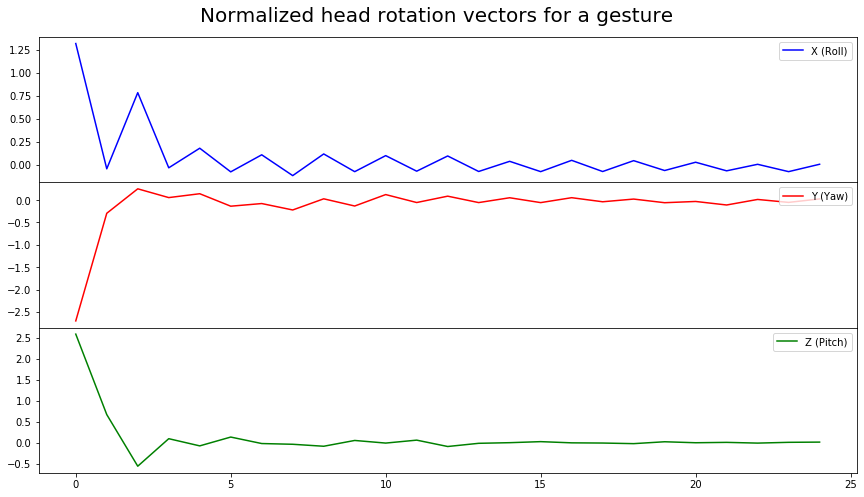

In [12]:
plot_gesture(pre.transform(X_train[0]))

In [13]:
# Transform the datasets
X_train, X_val, X_test = pre.transform(X_train), pre.transform(X_val), pre.transform(X_test)

In [14]:
# Create a function for displaying results (accuracy and confusion matrix)
def show_results(acc, cm, dataset, labels):
    df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df, annot=True)
    plt.title('Confusion matrix for {} set predictions'.format(dataset), fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    # Fix for matplotlib bug that cuts off top/bottom of seaborn visualizations
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.show()
    print('Accuracy: {:.2f}%'.format(acc * 100))

## Gesture model class

A gesture model $\lambda_i$ is represented by a HMM which is trained on the observations of a particular gesture.

- **Emission distributions**: The emission distribution for each state can be modeled as a multivariate Gaussian over each of the rotation axes. `pg.MultivariateGaussianDistribution` can be used to specify a multivariate Gaussian distribution with some confusion matrix and mean vector. If we assume that each rotation axis is independent, instead of using a `pg.MultivariateGaussianDistribution` with a diagonal covariance matrix of rotation axis variances, we define the distribution as a `pg.IndependentComponentsDistribution` composed of one `pg.NormalDistribution` for each rotation axis–this is because it appears that the parameters of a `pg.MultivariateGaussianDistribution` are learned during the Baum-Welch training algorithm, which may not be what we want. This is unclear because the only other alternative to setting the parameters would be to take the mean and covariances of the rotation axes over all observation examples in the training data, but this treats all of the training data as one long observation, which seems incorrect. Another potential problem with this model is that the same emission distribution is used for each state.

## Creating the gesture models

One gesture model $\lambda_i=(A_i,B_i,\pi_i)$ is initialized and trained for each of the gestures: `nd`, `mnd`, `sh`, `fd`, `t`, `ti`, `fu`.

In [15]:
models = []
for gesture in tqdm(gestures, desc='Training HMMs'):
    model = HMM(label=gesture, n_states=7, random_state=rand)
    model.set_uniform_initial()
    model.set_random_transitions()
    model.fit([X_train[i] for i, y_i in enumerate(y_train) if y_i == gesture])
    models.append(model)

In [16]:
clf = HMMClassifier()
clf.fit(models)

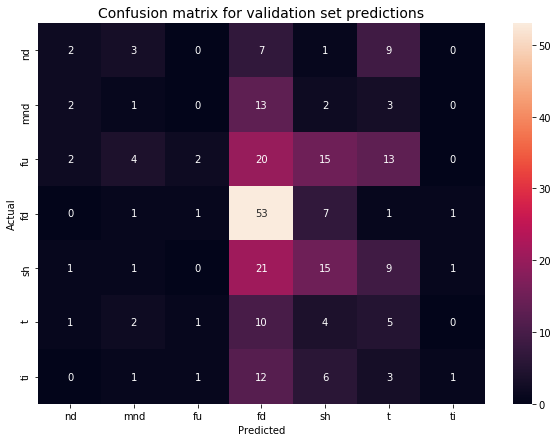

Accuracy: 30.62%


In [17]:
acc, cm = clf.evaluate(X_val, y_val)
show_results(acc, cm, dataset='validation', labels=gestures)

In [18]:
with np.printoptions(precision=3, suppress=True):
    display(models[0].initial)
    display(models[0].transitions)

array([0.892, 0.   , 0.108, 0.   , 0.   , 0.   , 0.   ])

array([[0.314, 0.606, 0.   , 0.076, 0.005, 0.   , 0.   ],
       [0.   , 0.531, 0.086, 0.372, 0.   , 0.01 , 0.   ],
       [0.   , 0.   , 0.592, 0.1  , 0.209, 0.046, 0.053],
       [0.   , 0.   , 0.   , 0.321, 0.63 , 0.049, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.625, 0.372, 0.002],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.412, 0.588],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ]])

In [22]:
# Create and fit a DTWKNN classifier using the single nearest neighbor and a radius of 1
# NOTE: The radius parameter is a parameter that constrains the FastDTW algorithm.
clf = DTWKNN(k=3, radius=5)
clf.fit(X_train, y_train)

In [25]:
%%time
acc, cm = clf.evaluate(X_val, y_val, labels=gestures, n_jobs=-1)

CPU times: user 182 ms, sys: 26.2 ms, total: 208 ms
Wall time: 13min 31s


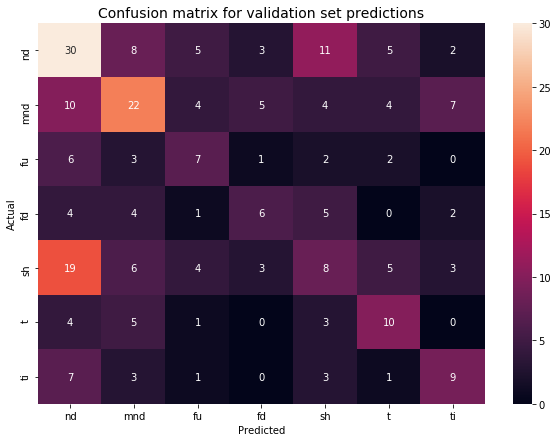

Accuracy: 35.66%


In [26]:
show_results(acc, cm, dataset='validation', labels=gestures)

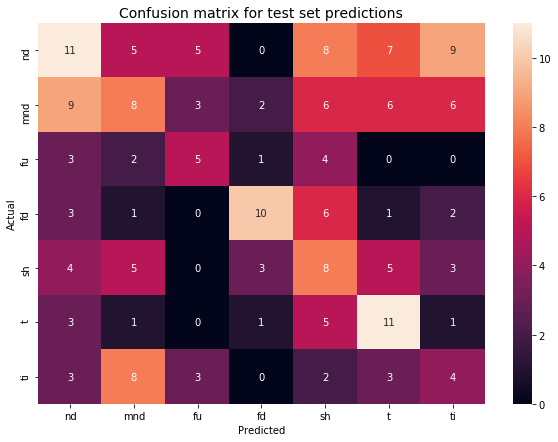

Accuracy: 29.08%
CPU times: user 485 ms, sys: 64.7 ms, total: 550 ms
Wall time: 10min 44s


In [27]:
# %%time
# acc, cm = clf.evaluate(X_test, y_test, labels=gestures, n_jobs=-1)
# show_results(acc, cm, dataset='test', labels=gestures)